In [1]:
# Connection
import mysql.connector
import sys

# Utility
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Preprocessing
# import string
from nltk import *
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') #pour pos_tag

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import wordnet as wn

# Modelling
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import keras.backend as K

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D , Activation, InputLayer, LSTM
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import (classification_report, confusion_matrix, 
                            f1_score,accuracy_score, precision_score, 
                             recall_score, roc_auc_score) 

#mlflow
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn

#wandb
import wandb
from wandb import AlertLevel

import logging

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
def connect():
    try:
        cnx = mysql.connector.connect(host="localhost",user="root",password="root",auth_plugin='mysql_native_password',database="sentiment_analysis")
    except mysql.connector.Error as err:
        cnx = False
        print(err)
        sys.exit(1)
    finally:
        return cnx

In [3]:
conn = connect()
conn
cursor = conn.cursor()

In [4]:
def create_dataframe():
    cursor.execute("""  SELECT *
                    FROM clothing_reviews; """)
    rows = cursor.fetchall()
    df = pd.DataFrame(rows,columns=['Index','Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'])
    df = df.set_index('Index')
    df = df.replace('',np.nan,regex = True)
    return df

In [5]:
df_ori = create_dataframe()

# Cleaning

In [6]:
#Suppression de 845 données car il nous faut absolument TOUTES les Review Text
df_ori.dropna(subset=['Review Text'], inplace=True)
# df_ori.isna().sum()

In [7]:
df = df_ori[["Review Text","Recommended IND"]]

In [8]:
stop_words = stopwords.words('english')

In [9]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('V'):
        return wn.VERB
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    else:
        return wn.NOUN

In [10]:
def cleaning(data):
    
    #1. Tokenize
    text_tokens = word_tokenize(data.replace("'", "").lower()) 
        
    #2. Remove Puncs
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]  
    
    #3. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    
    #4. Lemmatize
    POS_tagging = pos_tag(tokens_without_sw)
    wordnet_pos_tag=[]
    wordnet_pos_tag = [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in POS_tagging]
    wnl = WordNetLemmatizer()
    lemma = [wnl.lemmatize(word, tag) for word, tag in wordnet_pos_tag]
    
    return " ".join(lemma)

In [11]:
df['Document'] = df['Review Text'].apply(cleaning)
df

C:\Users\Admin\AppData\Local\Temp\ipykernel_24820\4105619847.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Document'] = df['Review Text'].apply(cleaning)


,Review Text,Recommended IND,Document
Index,,,
1,Absolutely wonderful - silky and sexy and comf...,1,absolutely wonderful silky sexy comfortable
2,Love this dress! it's sooo pretty. i happene...,1,love dress sooo pretty happen find store im gl...
3,I had such high hopes for this dress and reall...,0,high hope dress really wanted work initially o...
4,"I love, love, love this jumpsuit. it's fun, fl...",1,love love love jumpsuit fun flirty fabulous ev...
5,This shirt is very flattering to all due to th...,1,shirt flatter due adjustable front tie perfect...
...,...,...,...
23482,I was very happy to snag this dress at such a ...,1,happy snag dress great price easy slip flatter...
23483,"It reminds me of maternity clothes. soft, stre...",1,reminds maternity clothes soft stretchy shiny ...
23484,"This fit well, but the top was very see throug...",0,fit well top see never would work im glad able...


In [12]:
# df.to_csv('./datasets/df_cleaned.csv')

In [13]:
df = pd.read_csv("./datasets/df_cleaned.csv")

# Train-test split

In [14]:
X = df["Document"].values
y = df["Recommended IND"].values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 101)

# Test RandomUnderSampling

In [16]:
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train.reshape(-1, 1), y_train.reshape(-1, 1))

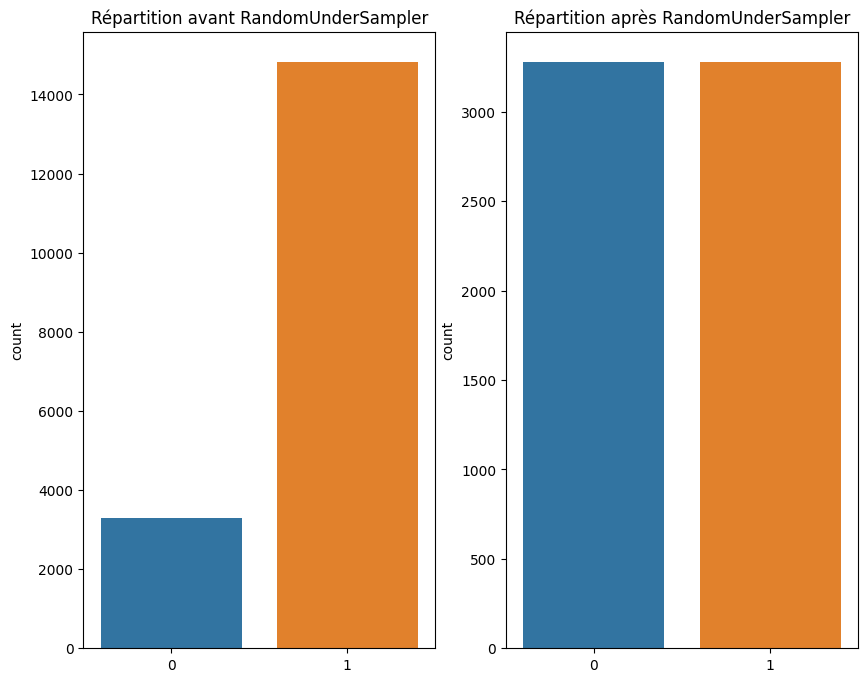

In [17]:
plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Répartition avant RandomUnderSampler')
plt.subplot(1, 2, 2)
sns.countplot(x=y_rus)
plt.title('Répartition après RandomUnderSampler')
plt.show()

# Modelisation

In [18]:
#Reshape en tableau pour passer dans le tokenizer
X_train_rus = X_rus.reshape(-1)
y_train_rus = y_rus.reshape(-1)

In [21]:
#Parametres

TOKENIZER_NUM_WORDS = None #None by default
SEQUENCE_LENGTH = 300 #None by default

# model
EPOCHS = 30
BATCH_SIZE = 1024

In [22]:
%%time

#Tokenize

tokenizer = Tokenizer(num_words=TOKENIZER_NUM_WORDS)
tokenizer.fit_on_texts(X_train_rus)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 6676
CPU times: total: 375 ms
Wall time: 379 ms


In [23]:
%%time
X_train_padseq_rus = pad_sequences(tokenizer.texts_to_sequences(X_train_rus), maxlen=SEQUENCE_LENGTH)
X_test_padseq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=SEQUENCE_LENGTH)

input_shape = X_train_padseq_rus.shape[1]

CPU times: total: 484 ms
Wall time: 501 ms


In [25]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [26]:
def LSTM_Model(train_x, train_y, neurons=10, optimizer='adam', vocab_size=vocab_size, input_shape=input_shape):
    lstm_model = Sequential()
    lstm_model.add(InputLayer(input_shape=(input_shape,)))
    lstm_model.add(Embedding(vocab_size,SEQUENCE_LENGTH,input_length=input_shape))
    lstm_model.add(LSTM(128, return_sequences=True)) #return sequences ?
    lstm_model.add(Flatten())
    lstm_model.add(Dense(1, activation="sigmoid"))
    #compile the model
    lstm_model.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=[f1_score])
    return lstm_model

In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, restore_best_weights=True)

In [28]:
lstm_model = LSTM_Model(train_x=X_train_padseq_rus,train_y=y_train_rus,vocab_size=vocab_size, input_shape=input_shape)

In [29]:
%%time
history = lstm_model.fit(X_train_padseq_rus, y_train_rus,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    callbacks=[early_stopping])

Epoch 1/30
5/5 [==============================] - 72s 14s/step - loss: 0.6263 - f1_score: 0.0833 - val_loss: 1.2505 - val_f1_score: 0.0000e+00
Epoch 2/30
5/5 [==============================] - 60s 12s/step - loss: 0.5965 - f1_score: 0.0000e+00 - val_loss: 1.2412 - val_f1_score: 0.0000e+00
Epoch 3/30
5/5 [==============================] - 70s 15s/step - loss: 0.5851 - f1_score: 0.0000e+00 - val_loss: 1.1931 - val_f1_score: 0.0000e+00
Epoch 4/30
5/5 [==============================] - 71s 15s/step - loss: 0.5442 - f1_score: 0.0170 - val_loss: 0.9623 - val_f1_score: 0.1668
Epoch 5/30
5/5 [==============================] - 72s 15s/step - loss: 0.4408 - f1_score: 0.4341 - val_loss: 0.6993 - val_f1_score: 0.8074
Epoch 6/30
5/5 [==============================] - 70s 14s/step - loss: 0.5196 - f1_score: 0.6484 - val_loss: 1.2388 - val_f1_score: 0.4092
Epoch 7/30
5/5 [==============================] - 80s 16s/step - loss: 0.3905 - f1_score: 0.4938 - val_loss: 0.5404 - val_f1_score: 0.8633
Epoch 8

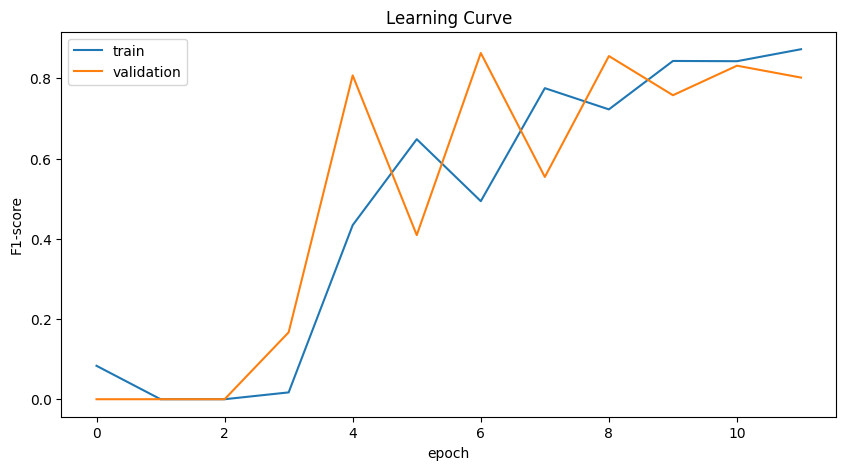

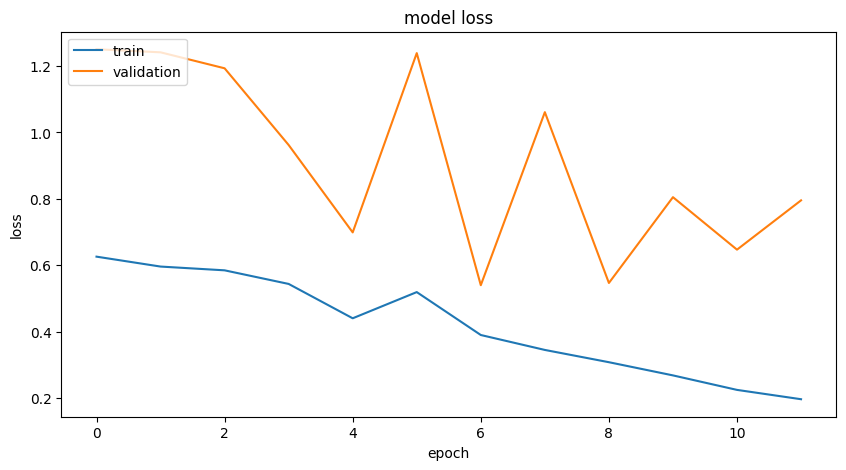

In [30]:
plt.figure(figsize=(10,5))

# summarize history for mae
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Learning Curve')
plt.ylabel('F1-score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Prediction

In [89]:
pred_train_lstm_rus = lstm_model.predict(X_train_padseq_rus)
pred_test_lstm = lstm_model.predict(X_test_padseq)

142/142 [==============================] - 38s 265ms/step


In [90]:
pred_test_lstm_proba = pred_test_lstm.copy()
pred_train_lstm_rus_proba = pred_train_lstm_rus.copy()

In [91]:
def predict_recommandation(pred_test_lstm):
    for i, x in enumerate(pred_test_lstm):
        if 0 <= x < 0.49:
            pred_test_lstm[i] = 0
        else:
            pred_test_lstm[i] = 1
    return pred_test_lstm

In [92]:
pred_test_lstm = predict_recommandation(pred_test_lstm)
pred_train_lstm_rus = predict_recommandation(pred_train_lstm_rus)

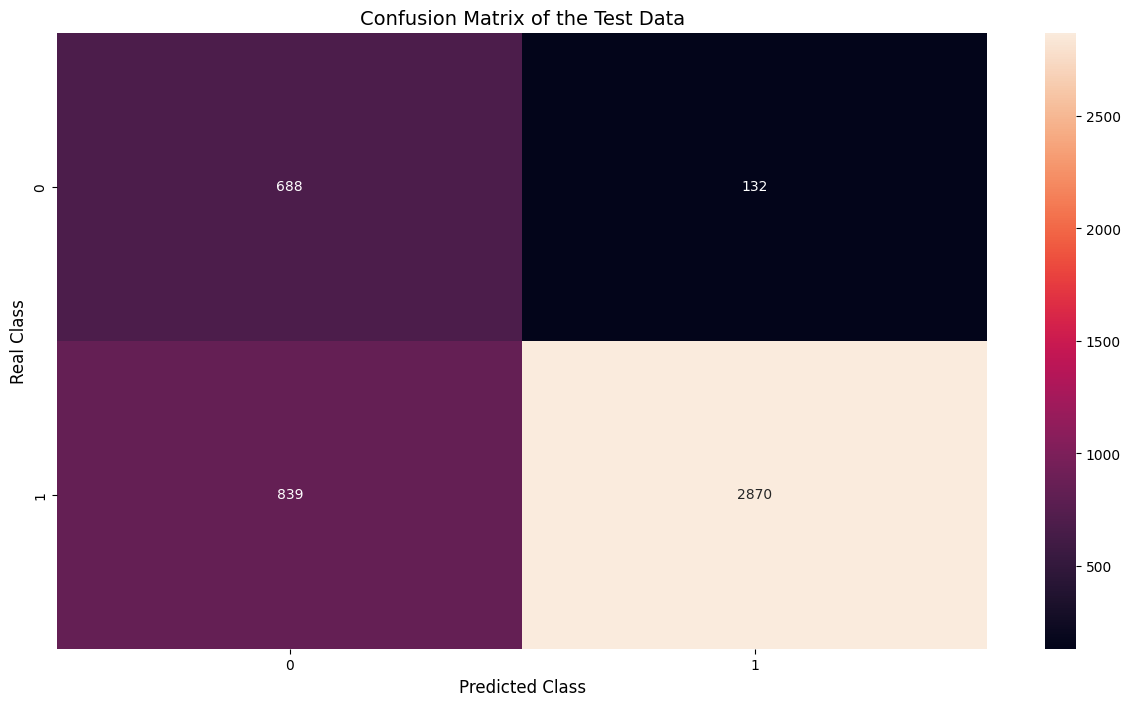

In [32]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=pred_test_lstm)
plt.figure(figsize=(15, 8))
sns.heatmap(conf_mat, annot=True, fmt='g')
plt.title('Confusion Matrix of the Test Data', fontsize=14)
plt.ylabel('Real Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.show()

In [33]:
print(classification_report(y_test, pred_test_lstm))

              precision    recall  f1-score   support

           0       0.45      0.84      0.59       820
           1       0.96      0.77      0.86      3709

    accuracy                           0.79      4529
   macro avg       0.70      0.81      0.72      4529
weighted avg       0.86      0.79      0.81      4529



In [34]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          2002800   
                                                                 
 lstm (LSTM)                 (None, 300, 128)          219648    
                                                                 
 flatten (Flatten)           (None, 38400)             0         
                                                                 
 dense (Dense)               (None, 1)                 38401     
                                                                 
Total params: 2,260,849
Trainable params: 2,260,849
Non-trainable params: 0
_________________________________________________________________


### Wandb

In [37]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ········


wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Admin/.netrc


True

In [38]:
wandb.init(project="sentiment-analysis")

wandb: Currently logged in as: marianne-depierre-simplon. Use `wandb login --relogin` to force relogin


In [101]:
Xday1, yday1 = X_test_padseq[0:905], y_test[0:905]
Xday2, yday2 = X_test_padseq[906:1811],y_test[906:1811]
Xday3, yday3 = X_test_padseq[1812:2717],y_test[1812:2717]
Xday4, yday4 = X_test_padseq[2717:3622],y_test[2717:3622]
Xday5, yday5 = X_test_padseq[3622:-1],y_test[3622:-1]

In [66]:
# def monitoring_metrics(pad_seq_X,y):
#     precision_neg = classification_report(y, lstm_model.predict(pad_seq_X),output_dict=True)['0']['precision']
#     recall_neg = classification_report(y, lstm_model.predict(pad_seq_X),output_dict=True)['0']['recall']
#     f1_score_neg = classification_report(y, lstm_model.predict(pad_seq_X),output_dict=True)['0']['f1-score']
#     precision_pos = classification_report(y, lstm_model.predict(pad_seq_X),output_dict=True)['1']['precision']
#     recall_pos = classification_report(y, lstm_model.predict(pad_seq_X),output_dict=True)['1']['recall']
#     f1_score_pos = classification_report(y, lstm_model.predict(pad_seq_X),output_dict=True)['1']['f1-score']
#     accuracy = classification_report(y, lstm_model.predict(pad_seq_X),output_dict=True)['accuracy']
#     wandb.log({'accuracy': accuracy, 'precision_pos':precision_pos, 'recall_pos':recall_pos, 'f1_score_pos':f1_score_pos,'precision_neg':precision_neg , 'recall_neg':recall_neg, 'f1_score_neg':f1_score_neg})
#     print("Monitoring metrics")

In [109]:
def monitoring_metrics(pad_seq_X,y):
    precision_neg = classification_report(y, pad_seq_X,output_dict=True)['0']['precision']
    recall_neg = classification_report(y, pad_seq_X,output_dict=True)['0']['recall']
    f1_score_neg = classification_report(y, pad_seq_X,output_dict=True)['0']['f1-score']
    precision_pos = classification_report(y, pad_seq_X,output_dict=True)['1']['precision']
    recall_pos = classification_report(y, pad_seq_X,output_dict=True)['1']['recall']
    f1_score_pos = classification_report(y, pad_seq_X,output_dict=True)['1']['f1-score']
    accuracy = classification_report(y, pad_seq_X,output_dict=True)['accuracy']
    return accuracy, precision_pos, recall_pos, f1_score_pos,precision_neg , recall_neg, f1_score_neg

In [102]:
Xday1_proba = lstm_model.predict(Xday1)
Xday1 = predict_recommandation(Xday1_proba)
Xday2_proba = lstm_model.predict(Xday2)
Xday2 = predict_recommandation(Xday2_proba)
Xday3_proba = lstm_model.predict(Xday3)
Xday3 = predict_recommandation(Xday3_proba)
Xday4_proba = lstm_model.predict(Xday4)
Xday4 = predict_recommandation(Xday4_proba)
Xday5_proba = lstm_model.predict(Xday5)
Xday5 = predict_recommandation(Xday5_proba)

29/29 [==============================] - 7s 251ms/step


In [113]:
monitoring_metrics(Xday1, yday1)
monitoring_metrics(Xday2, yday2)
monitoring_metrics(Xday3, yday3)
monitoring_metrics(Xday4, yday4)
monitoring_metrics(Xday5, yday5)

(0.7858719646799117,
 0.9528455284552846,
 0.7802929427430093,
 0.8579795021961931,
 0.4329896907216495,
 0.8129032258064516,
 0.5650224215246638)

In [115]:
monitoring_metrics(Xday1, yday1)[1]

0.9544715447154472

In [47]:
# precision_neg = classification_report(y_test, pred_test_lstm,output_dict=True)['0']['precision']
# recall_neg = classification_report(y_test, pred_test_lstm,output_dict=True)['0']['recall']
# f1_score_neg = classification_report(y_test, pred_test_lstm,output_dict=True)['0']['f1-score']
# precision_pos = classification_report(y_test, pred_test_lstm,output_dict=True)['1']['precision']
# recall_pos = classification_report(y_test, pred_test_lstm,output_dict=True)['1']['recall']
# f1_score_pos = classification_report(y_test, pred_test_lstm,output_dict=True)['1']['f1-score']
# accuracy = classification_report(y_test, pred_test_lstm,output_dict=True)['accuracy']

In [120]:
wandb.log({'accuracy': monitoring_metrics(Xday5, yday5)[0], 'precision_pos':monitoring_metrics(Xday5, yday5)[1], 'recall_pos':monitoring_metrics(Xday5, yday5)[2], 'f1_score_pos':monitoring_metrics(Xday5, yday5)[3],'precision_neg':monitoring_metrics(Xday5, yday5)[4], 'recall_neg':monitoring_metrics(Xday5, yday5)[5], 'f1_score_neg':monitoring_metrics(Xday5, yday5)[6]})

In [127]:
thresh = 0.75
f1_score_pos = 0.74698709
if f1_score_pos < thresh:
  wandb.alert(
    title="Alerte : F1-score bas", 
    text=f"Le F1-score {f1_score_pos} est inférieur au seuil fixé à {thresh}",
    level=AlertLevel.WARN
  )

In [153]:
# # saving tokenizer
# with open('./mypickles/tokenizer_rus.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [154]:
# # saving model lstm with rus
# lstm_model.save('./mypickles/lstm_model_rus.h5')